## Development of Class Structures for Analysis / Resampling of Replica Exchange

In [1]:
# Imports
import os, sys, math, glob
from datetime import datetime
import netCDF4 as nc
import numpy as np
from pymbar import timeseries, MBAR
import scipy.constants as cons
import mdtraj as md
#import dask.array as da
from copy import deepcopy
from datetime import datetime
import matplotlib.pyplot as plt

from Resample_RE import RE_Analyzer

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


In [2]:
fprint = lambda my_string: print(datetime.now().strftime("%m/%d/%Y %H:%M:%S") + ' // ' + str(my_string), flush=True)
get_kT = lambda temp: temp*cons.gas_constant
geometric_distribution = lambda min_val, max_val, n_vals: [min_val + (max_val - min_val) * (math.exp(float(i) / float(n_vals-1)) - 1.0) / (math.e - 1.0) for i in range(n_vals)]
rmsd = lambda a, b: np.sqrt(np.mean(np.sum((b-a)**2, axis=-1), axis=-1))

#### Initialize

In [3]:
#self = RE_Analyzer('../RE_test_cases/ligand_test_case/c3guano_99')
self = RE_Analyzer('../RE_test_cases/ligand_test_case/c3guano_full')
#self = RE_Analyzer('../RE_test_cases/ligand_test_case/c3_guano_full_alter')
#self = RE_Analyzer('../RE_test_cases/ligand_test_case/c3guano_99_alter')
#self = RE_Analyzer('../RE_test_cases/centroids/centroid_8_out/centroid_8_8')

10/03/2024 20:07:47 // Found storage directory at ../RE_test_cases/ligand_test_case/c3guano_full/saved_variables
10/03/2024 20:07:47 // Shapes of temperature arrays: [(0, (100,)), (1, (100,)), (2, (100,)), (3, (100,))]


#### Methods Showcase
1. Determine Interpolation Indices (indices of the last temp array that are missing from other temp arrays)
2. Obtain list of temperature arrays for each simulation
3. Obtain list of energies arrays, reshaped to (iter, state, state)
4. Obtain concatenated and backfilled energies (Needs testing on interpolated case)

In [4]:
interpolation_inds = self.determine_interpolation_inds()
print(interpolation_inds)

[[], [], [], []]


In [5]:
temps_list = self.obtain_temps()
print([temp_set.shape for temp_set in temps_list])

[(100,), (100,), (100,), (100,)]


In [6]:
energies_list = self.obtain_reshaped_energies(reduce=True)
print([ener_set.shape for ener_set in energies_list])

[(506, 100, 100), (501, 100, 100), (501, 100, 100), (501, 100, 100)]


In [7]:
# These come out reduced and properly ordered
backfilled_energies, _ = self.backfill_energies(energies_list)
print(backfilled_energies.shape)

(2009, 100, 100)


#### Perform Resampling of configurations and save as trajectory
1. Resample an interval
2. Resample from post-equilibration

In [8]:
#Get 50ns intervals:
intervals = []
sim_iterations = [ener_set.shape[0] for ener_set in self.obtain_reshaped_energies(reduce=True)]
for i, val in enumerate(sim_iterations):
    intervals.append([0, int(val) + int(np.sum(sim_iterations[:i]))])
#Intervals are pairs of starts and stops that will give 50ns (aggregate)
print(intervals)

[[0, 506], [0, 1007], [0, 1508], [0, 2009]]


In [9]:
pdb_in_fn = 'c3guano.pdb'
#2nd (0 - 100 ns) - Iterate over the intervals to do each 50ns set
start, stop = intervals[1]
interval_dcd_fn = os.path.join(self.input_dir, 'resampled', f"resampled_{start}_{stop}.dcd")
interval_pdb_fn = os.path.join(self.input_dir, 'resampled', f"resampled_{start}_{stop}.pdb")

resampled_trajectory = self.resample_an_interval(pdb_in_fn, start, stop, n_frames=500,
                                                 output_dcd=interval_dcd_fn,
                                                 output_pdb=interval_pdb_fn)

10/03/2024 20:07:51 // Resampling on interval 0 - 1007
10/03/2024 20:07:53 // Energies Retrieved
10/03/2024 20:08:04 // Auto equil is 592
10/03/2024 20:08:06 // Weights Retrieved
Flattened inds (41500, 2)
10/03/2024 20:08:06 // Resampled Configs
10/03/2024 20:08:06 // Positions Map Made
10/03/2024 20:08:15 // Done Resampling 500 on interval 0:1007


In [10]:
#Resample from post-equil samples
dcd_fn = os.path.join(self.input_dir, 'resampled', f"resampled_equil.dcd")
pdb_fn = os.path.join(self.input_dir, 'resampled', f"resampled_equil.pdb")
equil_resampled_traj = self.resample_from_post_equilibration(pdb_in_fn, n_frames=500,
                                                             output_dcd=dcd_fn, output_pdb=pdb_fn)

Flattened inds (68700, 2)


#### Make Some Plots
1. Plot the average energy of whole simulation
2. Determine the equilibration index
3. Plot the average energy of replciates from t0 to end
4. Plot histograms and timeseries(s) of energies from all replicates after equilibration
5. Extract a trajectory of a state, and plot the alpha carbon RMSD

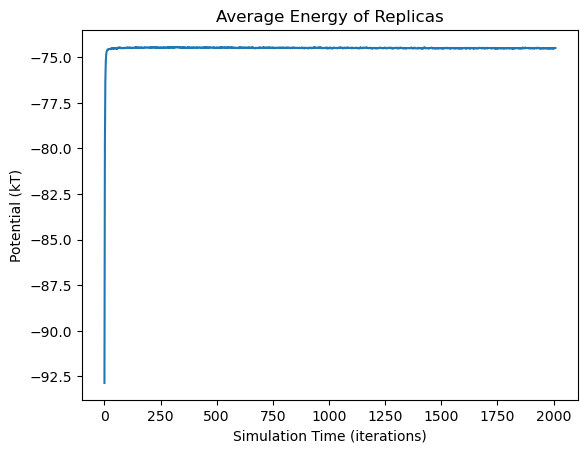

In [11]:
ave_energies = self.average_energy()
plt.clf()
_ = plt.plot(np.arange(ave_energies.shape[0]), ave_energies)
plt.title('Average Energy of Replicas')
plt.xlabel('Simulation Time (iterations)')
plt.ylabel('Potential (kT)')
plt.show()

In [12]:
t0, ave_energies_post_equil = self.determine_equilibration()

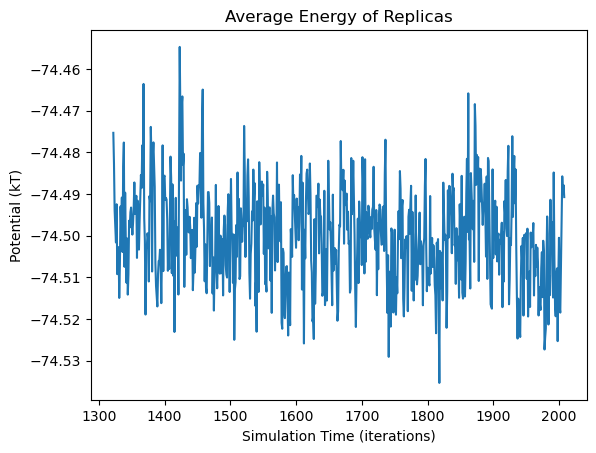

In [13]:
plt.clf()
_ = plt.plot(np.arange(t0, ave_energies_post_equil.shape[0]+t0), ave_energies_post_equil)
plt.title('Average Energy of Replicas')
plt.xlabel('Simulation Time (iterations)')
plt.ylabel('Potential (kT)')
plt.show()

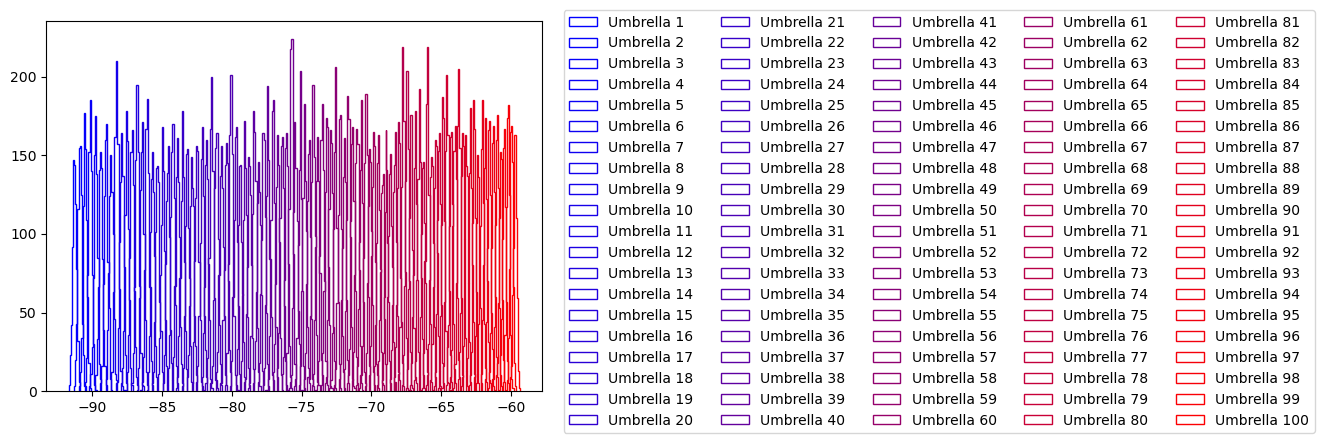

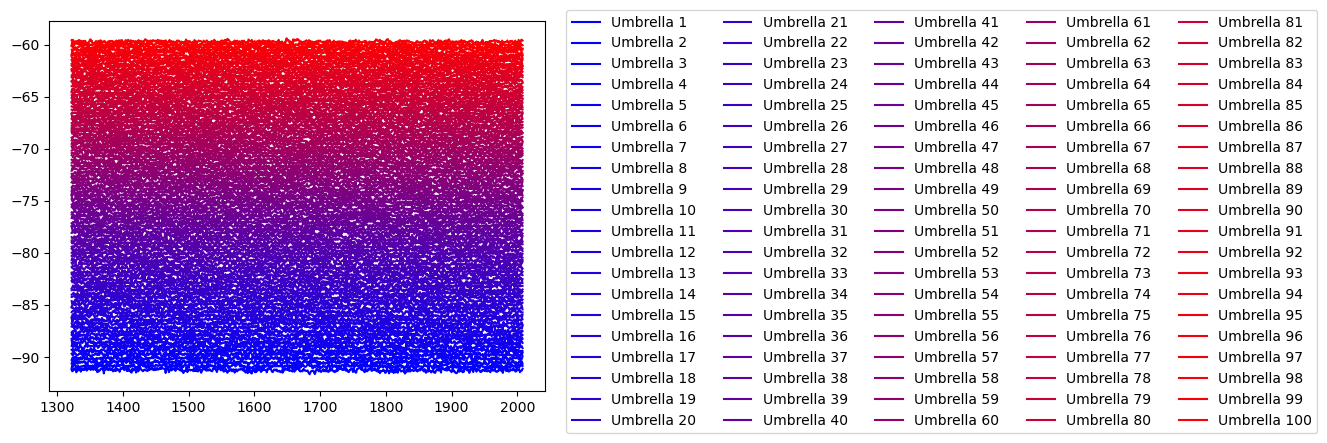

In [14]:
#Energies are already reduced
state_specific_eners = self.obtain_state_specific_energies(energies=backfilled_energies, reduce=False)[t0:]
num_replicates = state_specific_eners.shape[1]
num_iters = state_specific_eners.shape[0]

plt.clf()
for i in range(state_specific_eners.shape[1]):
    _ = plt.hist(state_specific_eners[:,i], color=(i/num_replicates,0,(1-i/num_replicates)), bins=10, histtype='step', label=f"Umbrella {i+1}")
plt.legend(loc='upper center', bbox_to_anchor=(1.8, 1.05), ncol=5)
plt.show()

plt.clf()
for i in range(state_specific_eners.shape[1]):
    _ = plt.plot(np.arange(t0, num_iters+t0), state_specific_eners[:,i], color=(i/num_replicates,0,(1-i/num_replicates)), label=f"Umbrella {i+1}")
plt.legend(loc='upper center', bbox_to_anchor=(1.8, 1.05), ncol=5)
plt.show()

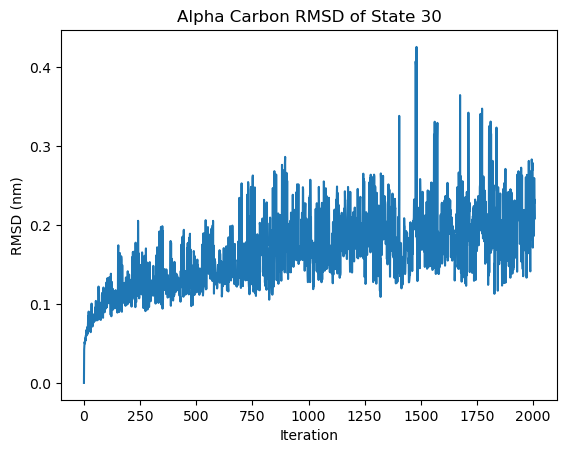

In [15]:
state_number = 30

traj = self.state_trajectory(state_number, '../RE_test_cases/ligand_test_case/c3guano_full/c3guano.pdb')
traj = traj.superpose(traj)
my_inds = traj.top.select('protein and name CA')
rmsd_vals = rmsd(traj.xyz[0, my_inds, :], traj.xyz[:, my_inds, :])

plt.clf()
_ = plt.plot(np.arange(rmsd_vals.shape[0]), rmsd_vals)
plt.title(f"Alpha Carbon RMSD of State {state_number}")
plt.xlabel('Iteration')
plt.ylabel('RMSD (nm)')
plt.show()